# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt
import geopandas as gpd
import adjustText as aT
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
from os.path import isfile, join
path = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/'
path_raw = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/raw/'

COMPARE TO [this](https://ourworldindata.org/covid-deaths)

### 1. Mapping the difference between simulated and true timing

### First just map the Zim districts 

In [5]:
# read in spatial data
# rawLocs = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp")
# trunkRoads = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/osm_trunk_roads.shp")

zw = gpd.read_file(path_raw +"shapefiles/new_districts/ZWE_adm2.shp")
trunkRoads = gpd.read_file(path_raw + "shapefiles/zwe_roads/Final_Zimbabwe_Roads_Version01.shp")



# merge the comparison data with the spatial district data on the district ID
# dataLocs = zw.merge(comparison, how="left", left_on=['ID_2'], right_on=['districtId'])

# there are some districts with no comparison data because they don't have data? 
#dataLocs.isna().sum()

<ipython-input-7-f8641362ae75>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zw["center"] = zw["geometry"].centroid


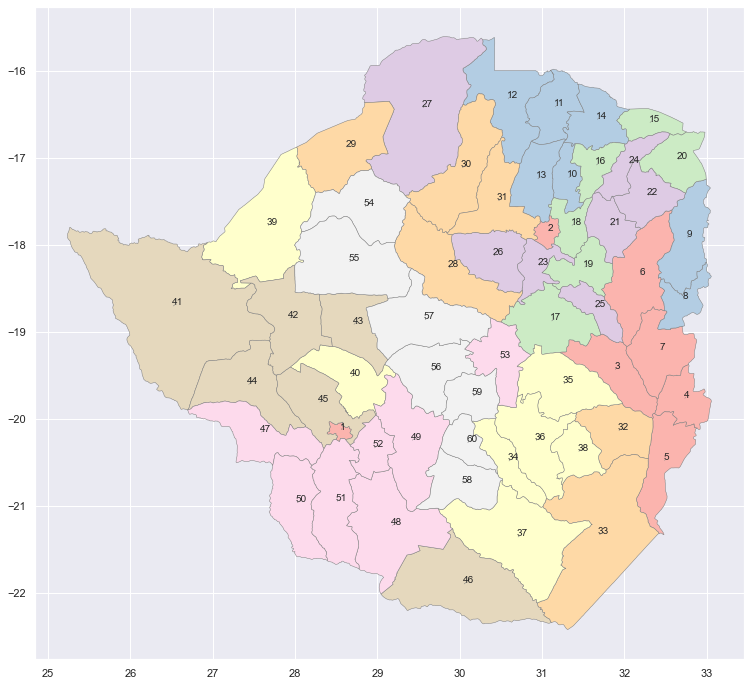

In [7]:
zw["center"] = zw["geometry"].centroid
zw_points = zw.copy()
zw_points.set_geometry("center", inplace = True)

ax = zw.plot(figsize = (15, 12), cmap = "Pastel1", edgecolor = "grey", linewidth = 0.5)
texts = []

for x, y, label in zip(zw_points.geometry.x, zw_points.geometry.y, zw_points["ID_2"]):
    texts.append(plt.text(x, y, label, fontsize = 10))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.savefig(path+'maps/numbered_districts.png', dpi=300,  facecolor='w', edgecolor='w', transparent=True)


<ipython-input-9-7843212cc295>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zw["center"] = zw["geometry"].centroid


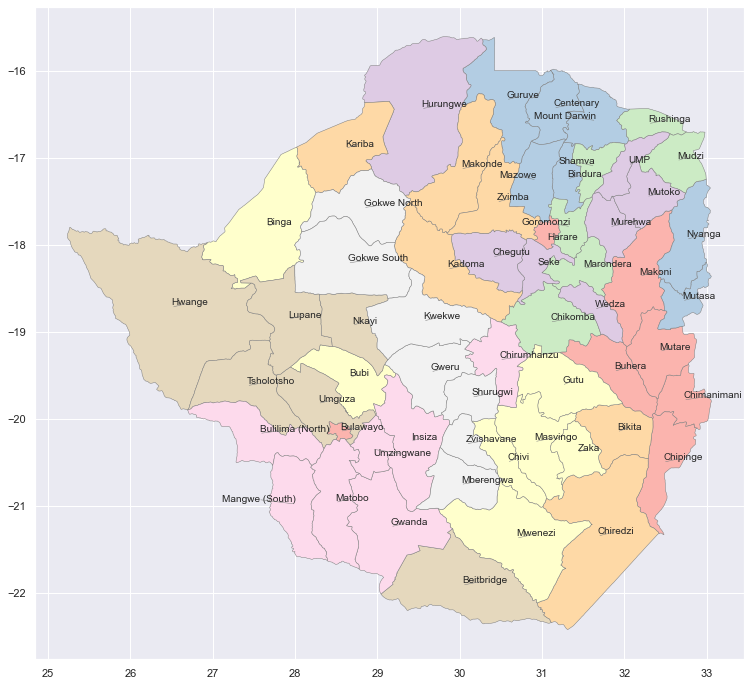

In [9]:
zw["center"] = zw["geometry"].centroid
zw_points = zw.copy()
zw_points.set_geometry("center", inplace = True)

ax = zw.plot(figsize = (15, 12), cmap = "Pastel1", edgecolor = "grey", linewidth = 0.5)
texts = []

for x, y, label in zip(zw_points.geometry.x, zw_points.geometry.y, zw_points["NAME_2"]):
    texts.append(plt.text(x, y, label, fontsize = 10))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

plt.savefig(path+'maps/named_districts.png', dpi=300,  facecolor='w', edgecolor='w', transparent=True)


In [81]:
# calculate the delta between true and simulated first recorded cases in number of days
comparison['diff'] = comparison['trueDay'] - comparison['simDay']
# convert nans to zeros on the diff field
comparison['diff'] = comparison['diff'].fillna(0) 
comparison.head()

,day,districtId,district_name_shpfile,cases_by_district_per_day,tot_cases_by_district,trueDay,simDay,diff
0,1,1,Bulawayo,1,1044,1,0.0,1.0
1,5,18,Goromonzi,1,35,5,0.0,5.0
2,35,26,Chegutu,3,104,35,77.0,-42.0
3,40,21,Murehwa,1,26,40,78.0,-38.0
4,57,17,Chikomba,1,17,57,106.0,-49.0


Red = simulated was faster than real

Blue = simulated was slower than real

In [85]:
myLim = 180

fig, ax = plt.subplots (figsize = (15,15))
dataLocs.plot("diff", ax = ax, legend=True, cmap='seismic', 
              missing_kwds={"color": "gray", "label": "Missing values",}, vmin=-myLim, vmax=myLim)

#trunkRoads.plot(ax=ax, color="black")

/opt/anaconda3/envs/i2p/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 1080x1080 with 2 Axes>

### 3. Exploring multiple sim outputs together

Sets of simulation results can also be explored in the aggregate.

In [72]:
outputFiles = [path+"exportMe9927.txt"]#"exportMe3324.txt", "exportMe4725.txt", "exportMe9812.txt", "exportMe2439.txt", "exportMe5343.txt", 
               #"exportMe6598.txt", "exportMe8992.txt", "exportMe7535.txt", "exportMe217.txt", "exportMe217.txt"]


In [73]:
# a helper function to read in and order a set of districts
def getOrderedDistricts(filename):
    
    # read and clean the data
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    
    # select the relevant columns, either cases or deaths
    cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
    #cases = r_data[r_data.metric_new_deaths > 0]
    
    # group by districts and sort by time
    byDistric = cases.groupby('districtId').agg({'time': 'min'})
    byDistric.sort_values(by="time")
    # sophie adding want to rename 'time' to denote the day of simulation
    byDistric.rename(columns={'time':'simDay'}, inplace=True)
    return byDistric
    
# read in the gold standard data
gold_filename = path+"../preprocessed/line_list/true.txt"
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']]

In [74]:
# iterate through the set of exported results files and append them to one another

simRuns = pd.NA # intial empty file

for x in outputFiles: # iterating over files
    try:
        simRuns = simRuns.append(getOrderedDistricts(x))
    except:
        simRuns = getOrderedDistricts(x)

# aggregate by the mean time associated with the district
simAgg = simRuns.groupby('districtId').agg({'simDay': 'mean'})

In [77]:
# additional helper functions

def getAggDailyCounts(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    dailies = r_data.groupby('time').agg({'metric_new_cases_sympt': 'sum', 'metric_new_cases_asympt': 'sum'})
    dailies.sort_values(by="time")
    return dailies

def getRawData(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return r_data

simRuns = pd.NA

for x in outputFiles:
    myCounts = getRawData(x)
    myCounts['key'] = [x for i in range(len(myCounts))]
    try:
        simRuns = simRuns.append(myCounts)
    except:
        simRuns = myCounts

simAgg = simRuns.groupby('time').agg({'metric_new_cases_sympt': 'mean', 'metric_new_cases_asympt': 'mean'})
simAgg.head()

,metric_new_cases_sympt,metric_new_cases_asympt
time,,
0,0.133333,0.2
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0
